# WCS plate solving

In this example, we use photutils to detect some stars in an example image, and find its WCS based on the RA-DEC of the image and the telescope field-of-view

## Image and sources

We start by loading an example image from photutils

In [1]:
from photutils.datasets import load_star_image
from astropy.stats import sigma_clipped_stats
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

hdu = load_star_image()
cutout = Cutout2D(hdu.data, (200, 200), 400, wcs=WCS(hdu.header))
data, true_wcs = cutout.data, cutout.wcs
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  

Changed DATE-OBS from '29/11/51          ' to '1951-11-29''. [astropy.wcs.wcs]


And we detect the 12 brighest sources in the image, that will be compared to catalog stars to compute the WCS

In [2]:
from photutils.segmentation import SourceFinder, SourceCatalog

segmented = SourceFinder(5)(data - median, 6*std)
cat = SourceCatalog(data, segmented)
xy = cat.to_table().to_pandas().sort_values("area", ascending=False)[["xcentroid", "ycentroid"]].values[0:12]

/opt/homebrew/Caskroom/miniforge/base/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Deblending: 100%|████████████████████████████| 127/127 [00:00<00:00, 356.85it/s]


Here is our field and reference stars

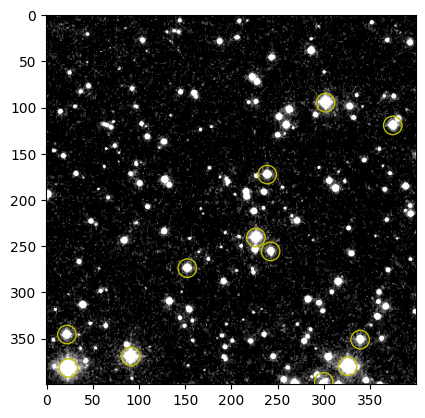

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture

plt.imshow(data, vmin=np.median(data), vmax=1.5*np.median(data), cmap="Greys_r")
_ = CircularAperture(xy, r=10.0).plot(color='y')

## Plate solving

We can now plate solve using twirl. 

We first compute the center RA-DEC of the image and its field-of-view (usually known for a given telescope but taken here from the original wcs)

In [4]:
from astropy.wcs.utils import proj_plane_pixel_scales

fov = (data.shape * proj_plane_pixel_scales(true_wcs))[0]
center = true_wcs.pixel_to_world(*np.array(data.shape)/2)

We query the Gaia stars RA-DEC in this field (a bit larger to have more stars)

In [5]:
from twirl import gaia_radecs

all_radecs = gaia_radecs(center, 1.2*fov)

And we compute the wcs based on the detected stars against the queried Gaia stars

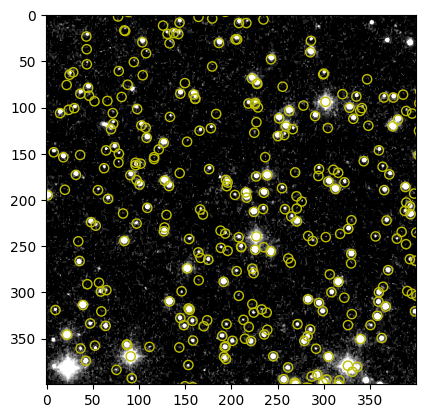

In [6]:
from twirl import compute_wcs

wcs = compute_wcs(xy, all_radecs[0:12], tolerance=10)

# plotting to check the WCS
radecs_xy = np.array(wcs.world_to_pixel_values(all_radecs))
plt.imshow(data, vmin=np.median(data), vmax=1.5*np.median(data), cmap="Greys_r")
_ = CircularAperture(radecs_xy, 5).plot(color="y")